Econometrics Analysis
- evaluate the popularuty of a song and the impact of different factors


In [13]:
import pandas as pd
import os

# PATH TO THE DATASET GENERATED BY THE LDA NOTEBOOK
DATA_PATH = "data/pop_lyrics_final_features.parquet"

if os.path.exists(DATA_PATH):
    df_filtered = pd.read_parquet(DATA_PATH)
    print(f"Loaded {len(df_filtered)} songs with topic features.")
else:
    print(f"ERROR: {DATA_PATH} not found.")
    print("Please run the 'code_pop_2.ipynb' notebook first to generate topic assignments.")
    # Fallback/Placeholder if file missing (for logic check)
    df_filtered = pd.DataFrame()

Loaded 86000 songs with topic features.


In [14]:
df_filtered.info()

<class 'pandas.DataFrame'>
RangeIndex: 86000 entries, 0 to 85999
Data columns (total 58 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 85997 non-null  str    
 1   artist                86000 non-null  str    
 2   year                  86000 non-null  int64  
 3   views                 86000 non-null  int64  
 4   lyrics                86000 non-null  str    
 5   clean_lyrics          86000 non-null  str    
 6   popularity            86000 non-null  str    
 7   is_top                86000 non-null  int64  
 8   sentiment_compound    86000 non-null  float64
 9   sentiment_pos         86000 non-null  float64
 10  sentiment_neg         86000 non-null  float64
 11  sentiment_neu         86000 non-null  float64
 12  anger                 86000 non-null  float64
 13  anticipation          86000 non-null  float64
 14  disgust               86000 non-null  float64
 15  fear                  86000 no

In [25]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Topic Label Mapping (matching code_pop_2 for better interpretability)
TOPIC_LABELS = {
    0: "Seeking help / moral reflection",
    1: "Street violence & instability",
    2: "Party repetition / structural noise",
    3: "Aspirational escape & hope imagery",
    4: "Conflict, loss of control & anger",
    5: "Club / dancefloor energy",
    6: "Sensual pop & pleasure",
    7: "Sentimental melancholy & seasonal sadness",
    8: "Material hardship & working-class frustration",
    9: "Dark atmospheric imagery & death",
    10: "Collective trauma, war & religion",
    11: "Music meta & celebration",
    12: "Migration, city life & life trajectory",
    13: "Personal loss, isolation & heartbreak",
}

Training XGBoost Regressor on 68800 songs...


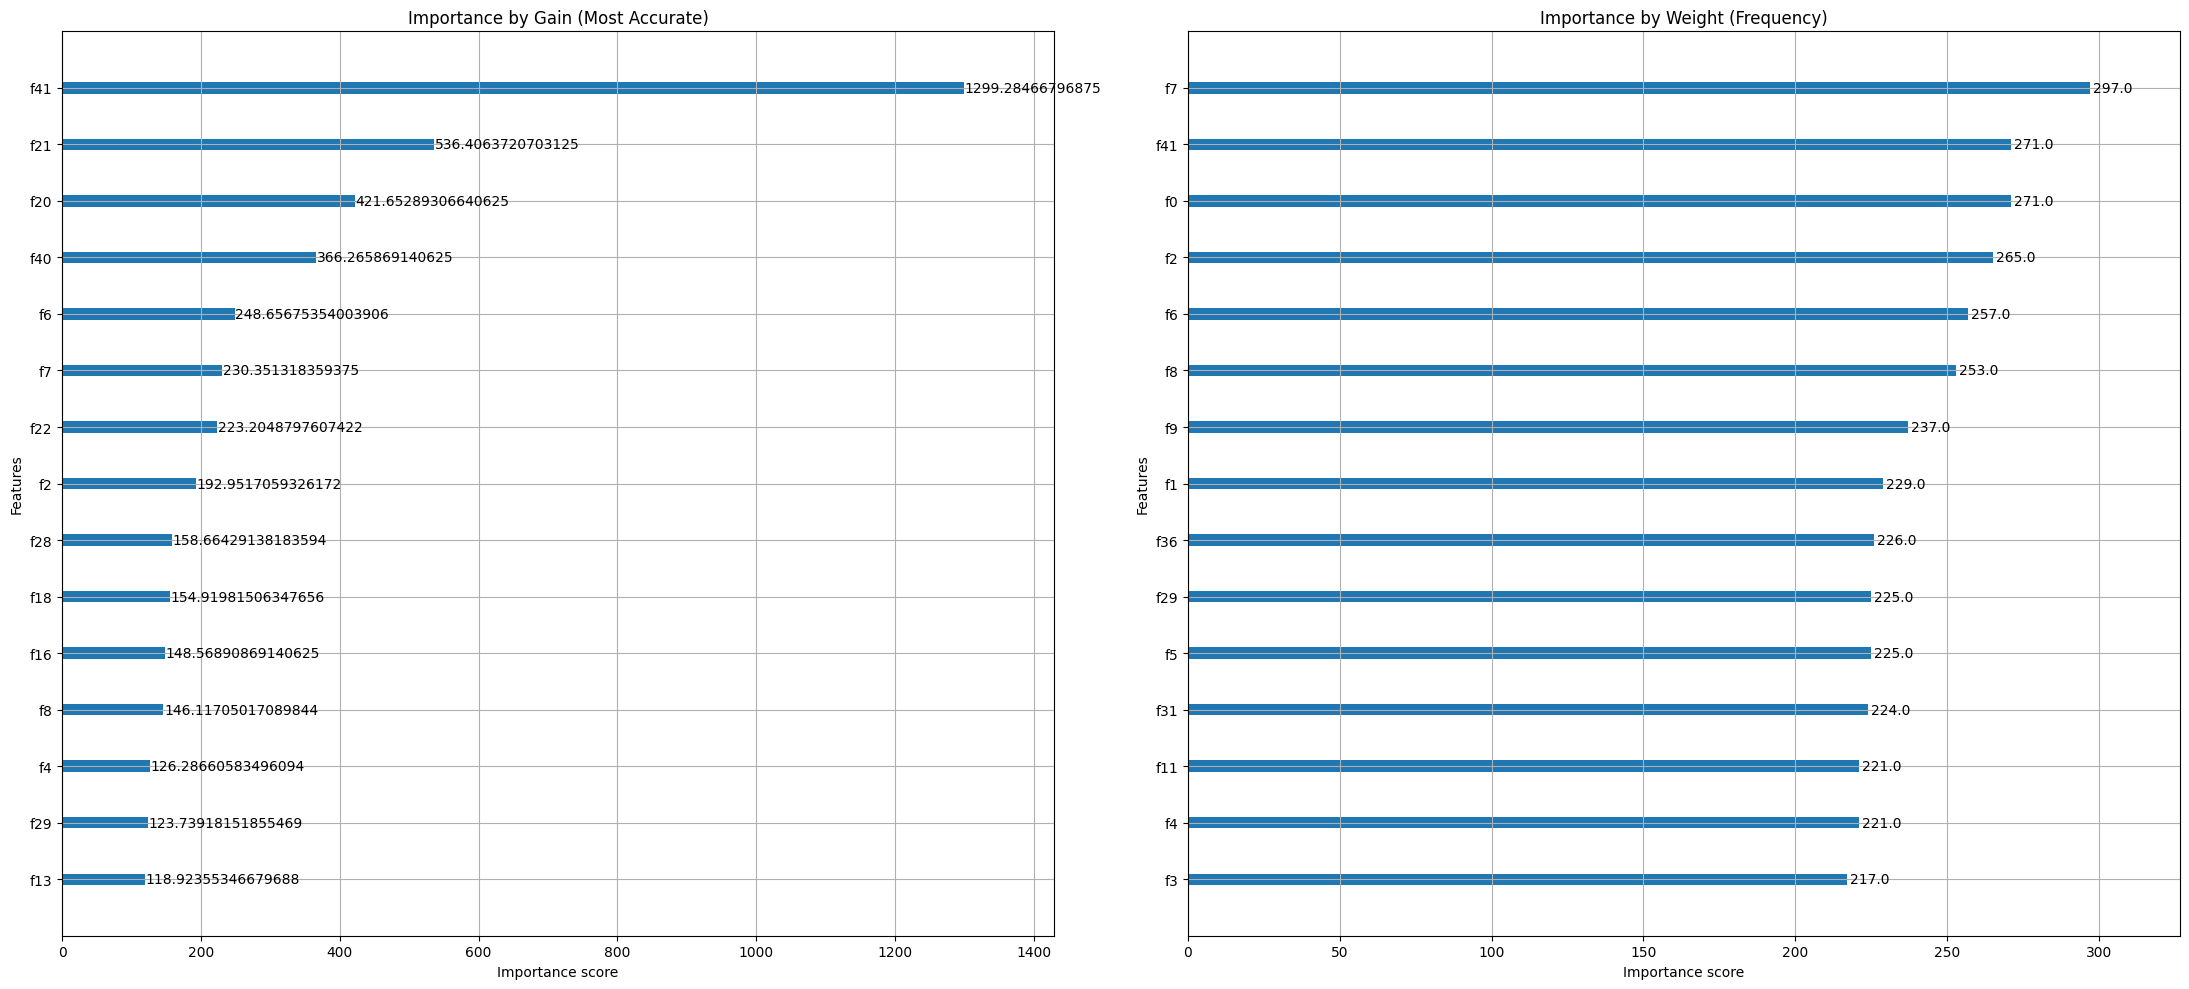


TOP 20 MOST INFLUENTIAL Lyrical Features (Gain)
                                                     Feature     Gain
                                        Flesch Kincaid Grade 0.182348
    Primary Topic: Sentimental melancholy & seasonal sadness 0.075282
                       Primary Topic: Sensual pop & pleasure 0.059177
                                         Flesch Reading Ease 0.051404
                       Topic Mixture: Sensual pop & pleasure 0.034898
    Topic Mixture: Sentimental melancholy & seasonal sadness 0.032329
Primary Topic: Material hardship & working-class frustration 0.031326
          Topic Mixture: Party repetition / structural noise 0.027080
                                          Sentiment Compound 0.022268
            Primary Topic: Conflict, loss of control & anger 0.021742
          Primary Topic: Party repetition / structural noise 0.020851
Topic Mixture: Material hardship & working-class frustration 0.020507
            Topic Mixture: Conflict, loss

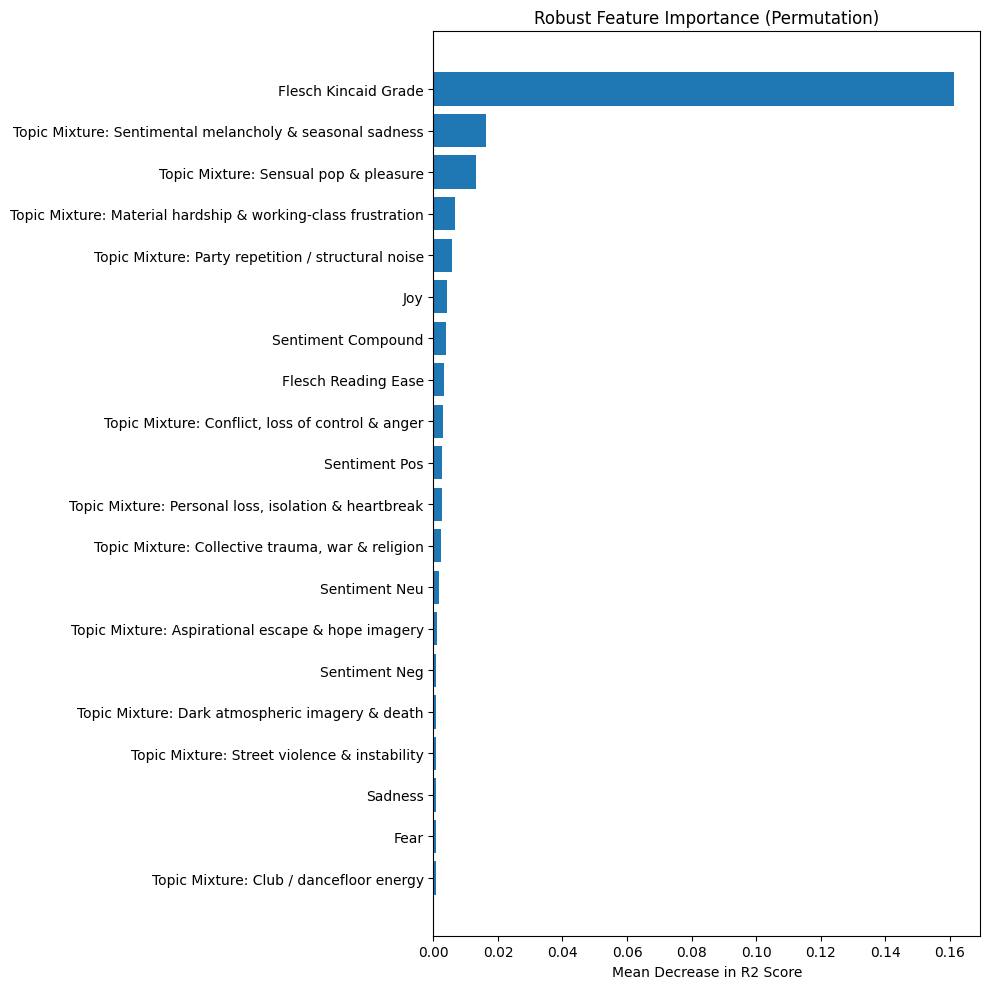

In [26]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Feature Engineering
def prepare_features(df_input):
    df_features = df_input.copy()
    
    # 1. Basic Lyrics Scores
    df_features['lexical_diversity'] = df_features['clean_lyrics'].apply(
        lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
    )
    
    # 2. Topic Features
    prob_cols = [c for c in df_input.columns if c.endswith('_prob')]
    id_cols = [c for c in df_input.columns if c.startswith('topic_id_')]
    
    # 3. Sentiment & Emotion Features
    sentiment_cols = ['sentiment_compound', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu']
    emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    readability_cols = ['flesch_reading_ease', 'flesch_kincaid_grade']
    
    existing_nlp_cols = [c for c in sentiment_cols + emotion_cols + readability_cols if c in df_input.columns]
    
    # 4. Define final feature matrix and target
    feature_cols = prob_cols + id_cols + existing_nlp_cols
    
    # Target: Views (Log transform)
    df_features['target_views'] = np.log1p(df_features['views'])
    
    # Ensure all feature columns are numeric
    X_data = df_features[feature_cols].copy()
    for col in X_data.columns:
        X_data[col] = pd.to_numeric(X_data[col], errors='coerce').fillna(0)
    
    # Mapping readable names for plotting
    readable_feature_names = []
    for col in feature_cols:
        if 'topic_id_' in col:
            idx = int(col.split('_')[-1])
            readable_feature_names.append(f"Primary Topic: {TOPIC_LABELS.get(idx, col)}")
        elif '_prob' in col:
            idx = int(col.split('_')[1])
            readable_feature_names.append(f"Topic Mixture: {TOPIC_LABELS.get(idx, col)}")
        else:
            readable_feature_names.append(col.replace('_', ' ').title())
            
    return X_data, df_features['target_views'], readable_feature_names

# Prepare data
X, y, feature_names = prepare_features(df_filtered)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set feature names on DataFrame to ensure XGBoost uses them
X_train.columns = feature_names
X_test.columns = feature_names

# Training XGBoost
print(f"Training XGBoost Regressor on {len(X_train)} songs...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 1. Multi-Type Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Gain: Total gain of the scores which the feature contributes to
xgb.plot_importance(model, importance_type='gain', max_num_features=15, ax=ax1, title="Importance by Gain (Most Accurate)")
# Weight: Number of times a feature is used to split the data across all trees
xgb.plot_importance(model, importance_type='weight', max_num_features=15, ax=ax2, title="Importance by Weight (Frequency)")

plt.tight_layout()
plt.show()

# 2. Print Importance Table
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': model.feature_importances_
}).sort_values('Gain', ascending=False)

print("\n" + "="*50)
print("TOP 20 MOST INFLUENTIAL Lyrical Features (Gain)")
print("="*50)
print(importance_df.head(20).to_string(index=False))
print("="*50)

# 3. Permutation Importance
print("\nCalculating Permutation Importance (more robust)...")
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-20:]

plt.figure(figsize=(10, 10))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Mean Decrease in R2 Score")
plt.title("Robust Feature Importance (Permutation)")
plt.tight_layout()
plt.show()